In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
np.random.seed(42) # definindo uma seed global 

In [4]:
path = "/content/drive/MyDrive/datasets/spam/"

In [5]:
df = pd.read_csv(os.path.join(path, 'spam.csv'), encoding="ISO-8859-1")

In [6]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [7]:
df.rename(columns={"v1": "target", "v2": "sms"}, inplace=True)

In [8]:
sample = 5
df['sms'][sample], df['target'][sample]

("FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",
 'spam')

In [9]:
t = df['sms'][sample]

In [10]:
def normalize(text):
    preprocessed = text.lower()
    preprocessed = preprocessed.translate(
        str.maketrans('', '', string.punctuation)
    )

    return preprocessed

In [11]:
def tokenize(text):
    return text.split(' ')

In [12]:
t

"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"

In [13]:
normalize(t)

'freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send å£150 to rcv'

In [14]:
tokenize(normalize(t))

['freemsg',
 'hey',
 'there',
 'darling',
 'its',
 'been',
 '3',
 'weeks',
 'now',
 'and',
 'no',
 'word',
 'back',
 'id',
 'like',
 'some',
 'fun',
 'you',
 'up',
 'for',
 'it',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chgs',
 'to',
 'send',
 'å£150',
 'to',
 'rcv']

In [15]:
messages = df['sms'].apply(normalize).values.astype(str)

In [16]:
messages, len(messages)

(array(['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
        'ok lar joking wif u oni',
        'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s',
        ..., 'pity  was in mood for that soany other suggestions',
        'the guy did some bitching but i acted like id be interested in buying something else next week and he gave it to us for free',
        'rofl its true to its name'], dtype='<U888'), 5572)

In [17]:
all_tokens = []
for message in messages:
    # tokenize retorna uma lista de tokens
    tokens = tokenize(message)

    # OBS: tokens é uma lista
    all_tokens.extend(tokens)

In [18]:
len(all_tokens)

86961

In [19]:
unique_tokens, counts = np.unique(all_tokens, return_counts=True)

In [20]:
len(unique_tokens)

9565

In [21]:
unique_tokens

array(['', '\rham', '0', ..., 'ì©', 'ìï', 'ìïll'], dtype='<U52')

In [22]:
counts

array([1854,    1,    3, ...,    3,   52,    1])

In [23]:
unique_tokens = unique_tokens[counts.argsort()[::-1]]
counts = counts[counts.argsort()[::-1]]

In [24]:
unique_tokens

array(['to', 'i', 'you', ..., 'mineall', 'minecraft', 'kill'],
      dtype='<U52')

In [25]:
counts

array([2240, 2230, 2124, ...,    1,    1,    1])

In [26]:
unique_tokens[:10]

array(['to', 'i', 'you', '', 'a', 'the', 'u', 'and', 'is', 'in'],
      dtype='<U52')

In [27]:
vocab = {
    w: i for i, w in enumerate(unique_tokens)
}

In [28]:
len(unique_tokens)

9565

In [29]:
m = messages[0]

In [30]:
u, c = np.unique(tokenize(m), return_counts=True)

In [31]:
u

array(['amore', 'available', 'buffet', 'bugis', 'cine', 'crazy', 'e',
       'go', 'got', 'great', 'in', 'jurong', 'la', 'n', 'only', 'point',
       'there', 'until', 'wat', 'world'], dtype='<U9')

In [32]:
c = c / sum(c)

In [33]:
c

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [34]:
vec = np.zeros([len(unique_tokens)])

for ui, ci in zip(u, c):
    index = vocab[ui]
    vec[index] = ci

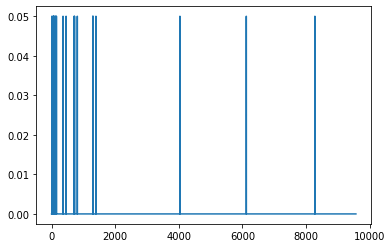

In [35]:
plt.plot(vec)

In [36]:
def vectorize(tokens, vocab):
    vec = np.zeros([len(vocab)])
    u, c = np.unique(tokens, return_counts=True)
    c = c / sum(c)

    for ui, ci in zip(u, c):
        index = vocab[ui]
        vec[index] = ci

    return vec

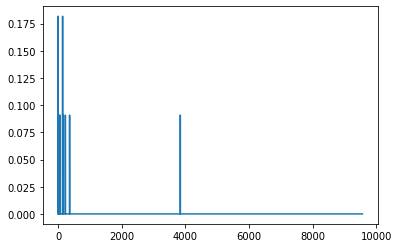

In [37]:
plt.plot(vectorize(tokenize(messages[3]), vocab))

## Criando um dataset para classificação

In [38]:
df['target'].values

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype=object)

In [39]:
y = np.array([0 if t == 'ham' else 1 for t in df['target'].values])

In [40]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [41]:
messages = df['sms'].apply(normalize).values.astype(str)

In [42]:
X = []
for message in messages:
    tokens = tokenize(message)
    x = vectorize(tokens, vocab)
    X.append(x)
X = np.array(X)

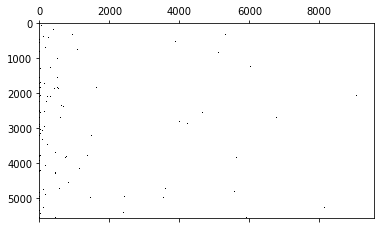

In [43]:
plt.spy(X, cmap='binary')

## Tarefa de Casa

* 1. Fazer uma análise exploratória no conjunto de dados.
  * 1.1. Enumerar as 20 tokens mais frequentes em um barplot.
  * 1.2. Analisar a distribuição das amostras por classe. Quantas mensagens são spam? Quantas mensagens são verdadeiras? As classes são balanceadas? => pesquisar, se for o caso, quais os impactos de classes não balanceadas
* 2. Criar um classificador de mensagens spam. Usar a matriz de dados $X$ e o vetor de labels $y$.
  * OBS: Não precisa implementar os classificadores do zero, podem usar os classificadores do scikit-learn. Recomendações: Logistic Regression, e SVM (kernel linear ou RBF), MLPs se quiserem.
  * 2.1. Fazer a divisão treino-teste usando scikit-learn.

# Análise exploratória

## Tokens mais frequentes

In [44]:
def map_occurrences(string_list):
  string_count = {}
  for item in string_list:
      if item not in string_count:
          count = string_list.count(item)
          string_count[item] = count
  return string_count

In [45]:
tokens_occurrences = map_occurrences(all_tokens)
sorted_tokens_occurrences = {k: v for k, v in sorted(tokens_occurrences.items(), key=lambda item: item[1], reverse=True)}

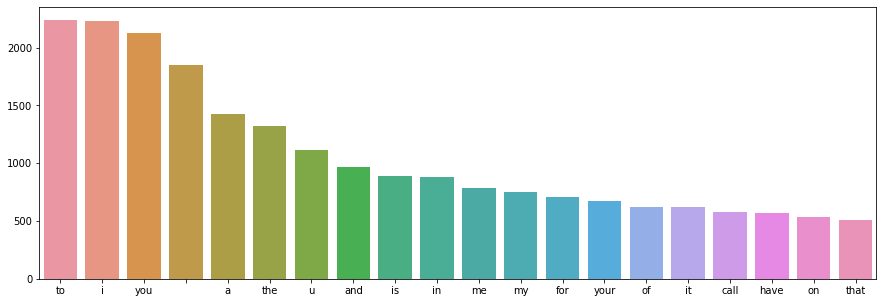

In [46]:
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=list(sorted_tokens_occurrences.keys())[:20], y=list(sorted_tokens_occurrences.values())[:20], ax=ax, data=df);

In [47]:
df['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

# Classificador

In [48]:
def show_metrics(yts, y_pred):
  print('-----Métricas-----')
  print('Acurácia: %.2f' % accuracy_score(yts, y_pred))
  print('Precisão: %.2f' % precision_score(yts, y_pred))
  print('Recall: %.2f' % recall_score(yts, y_pred))
  print('F-score: %.2f' % f1_score(yts, y_pred))

  cmat = confusion_matrix(yts, y_pred)
  ax = sns.heatmap(cmat.astype(int), annot=True, fmt='g')
  _ = ax.set_xticklabels(['ham', 'spam'])
  _ = ax.set_yticklabels(['ham', 'spam'], rotation=90)

  ax.set_ylabel('Classe Real')
  ax.set_xlabel('Classe Predita')

  print('------------------')
  print('Matriz de confusão:')

In [49]:
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.2, stratify=y)

## Regressão Logística

-----Métricas-----
Acurácia: 0.87
Precisão: 0.00
Recall: 0.00
F-score: 0.00
------------------
Matriz de confusão:


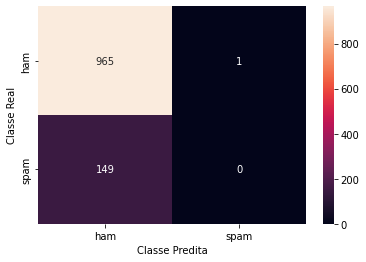

In [50]:
# Modelo de Classificação

# criando o modelo
model = LogisticRegression()

# treinando o modelo com o conjunto de treino
model.fit(Xtr, ytr)

# fazendo as predições no conjunto de teste
y_pred = model.predict(Xts)

# métricas de avaliação das predições
show_metrics(yts, y_pred)

## SVM

-----Métricas-----
Acurácia: 0.88
Precisão: 0.95
Recall: 0.12
F-score: 0.21
------------------
Matriz de confusão:


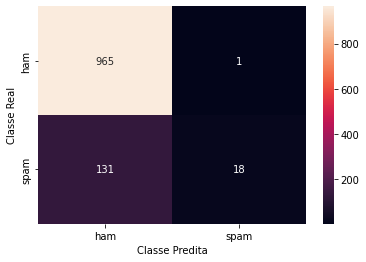

In [51]:
from sklearn import svm

# criando o modelo
model = svm.SVC(kernel='linear')

# treinando o modelo com o conjunto de treino
model.fit(Xtr, ytr)

# fazendo as predições no conjunto de teste
y_pred = model.predict(Xts)

# métricas de avaliação das predições
show_metrics(yts, y_pred)

## Regressão logística com sub-amostragem da classe dominante

In [52]:
# exibindo a distribuição de classes
print("Antes: ", Counter(ytr))

# definindo a estratégia de sub-amostragem
undersample = RandomUnderSampler(sampling_strategy=1)

# aplicando a transformação de reamostragem
Xtr, ytr = undersample.fit_resample(Xtr, ytr)

# exibindo a distribuição de classes
print("Depois: ", Counter(ytr))

Antes:  Counter({0: 3859, 1: 598})
Depois:  Counter({0: 598, 1: 598})


-----Métricas-----
Acurácia: 0.87
Precisão: 0.51
Recall: 0.92
F-score: 0.65
------------------
Matriz de confusão:


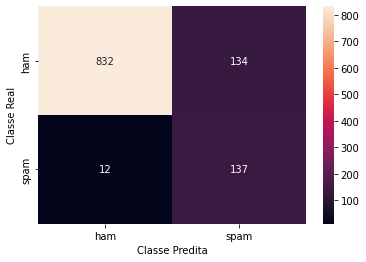

In [53]:
# Modelo de Classificação

# criando o modelo
model = LogisticRegression()

# treinando o modelo com o conjunto de treino
model.fit(Xtr, ytr)

# fazendo as predições no conjunto de teste
y_pred = model.predict(Xts)

# métricas de avaliação das predições
show_metrics(yts, y_pred)

## SVM com sub-amostragem da classe dominante

-----Métricas-----
Acurácia: 0.86
Precisão: 0.48
Recall: 0.93
F-score: 0.64
------------------
Matriz de confusão:


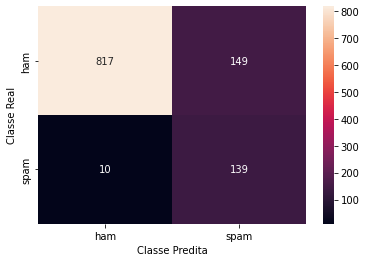

In [54]:
from sklearn import svm

# criando o modelo
model = svm.SVC(kernel='linear')

# treinando o modelo com o conjunto de treino
model.fit(Xtr, ytr)

# fazendo as predições no conjunto de teste
y_pred = model.predict(Xts)

# métricas de avaliação das predições
show_metrics(yts, y_pred)

# Regressão logistica com sub_amostragem e Removendo stop words, numeros, pontuação..

In [55]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
import re

def clean_text(text):
    """
    Realiza algumas operações de limpeza em uma string
    remove numeros
    remove pontuações
    substitui maisculas por minusculas
    remove espaços em branco repetidos
    """
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation])
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_no_doublespace

In [57]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('')

In [58]:
all_tokens = []
for message in messages:
    # tokenize retorna uma lista de tokens
    clean_message = clean_text(message)
    tokens = tokenize(clean_message)
    filtered_tokens = [w for w in tokens if not w in stop_words]

    # OBS: tokens é uma lista
    all_tokens.extend(filtered_tokens)

tokens_occurrences = map_occurrences(all_tokens)
sorted_tokens_occurrences = {k: v for k, v in sorted(tokens_occurrences.items(), key=lambda item: item[1], reverse=True)}

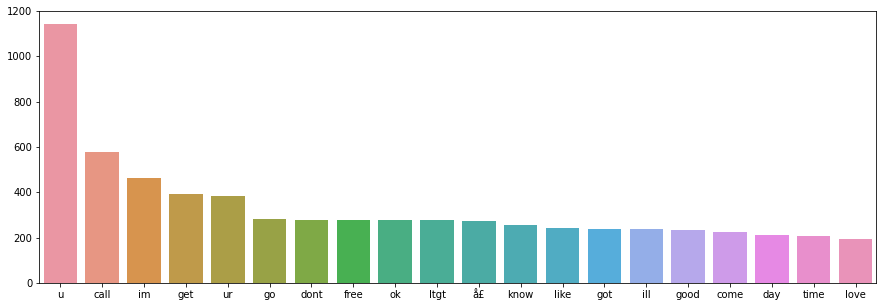

In [59]:
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=list(sorted_tokens_occurrences.keys())[:20], y=list(sorted_tokens_occurrences.values())[:20], ax=ax, data=df);

In [60]:
unique_tokens, counts = np.unique(all_tokens, return_counts=True)

unique_tokens = unique_tokens[counts.argsort()[::-1]]
counts = counts[counts.argsort()[::-1]]

vocab = {
    w: i for i, w in enumerate(unique_tokens)
}

X = []
for message in messages:
    clean_message = clean_text(message)
    tokens = tokenize(clean_message)
    filtered_tokens = [w for w in tokens if not w in stop_words]
    x = vectorize(filtered_tokens, vocab)
    X.append(x)
X = np.array(X)

-----Métricas-----
Acurácia: 0.94
Precisão: 0.75
Recall: 0.87
F-score: 0.80
------------------
Matriz de confusão:


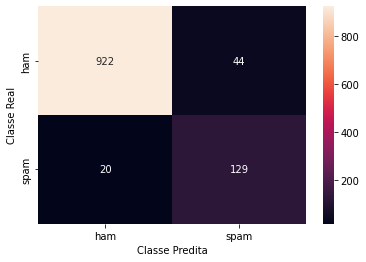

In [61]:
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.2, stratify=y)

# definindo a estratégia de sub-amostragem
undersample = RandomUnderSampler(sampling_strategy=1)

# aplicando a transformação de reamostragem
Xtr, ytr = undersample.fit_resample(Xtr, ytr)

# Modelo de Classificação

# criando o modelo
model = LogisticRegression()

# treinando o modelo com o conjunto de treino
model.fit(Xtr, ytr)

# fazendo as predições no conjunto de teste
y_pred = model.predict(Xts)

# métricas de avaliação das predições
show_metrics(yts, y_pred)

In [62]:
weights = model.coef_[0]

max_ind = weights.argsort()[-10:][::-1]
min_ind = weights.argsort()[:10][::-1]

vocab_by_id = dict((v, k) for k, v in vocab.items())

for i in max_ind:
  print(f'token: {vocab_by_id[i]}\tweight: {weights[i]:.2f}')
print('...')
for i in min_ind:
  print(f'token: {vocab_by_id[i]}\tweight: {weights[i]:.2f}')

token: å£	weight: 4.41
token: call	weight: 3.76
token: free	weight: 3.29
token: txt	weight: 2.70
token: mobile	weight: 2.21
token: text	weight: 2.13
token: stop	weight: 2.01
token: claim	weight: 2.01
token: reply	weight: 1.59
token: prize	weight: 1.52
...
token: later	weight: -1.07
token: home	weight: -1.08
token: u	weight: -1.17
token: come	weight: -1.20
token: sorry	weight: -1.38
token: good	weight: -1.43
token: ok	weight: -1.71
token: ill	weight: -1.81
token: ltgt	weight: -1.84
token: im	weight: -1.92
